In [33]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
       
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
        
        while sum(mask)>max_star:
            if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
        if switch==1:
            countsNo=countsNo+1
         
        
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)
    #print(v_to_age(kin_age,p_mr))
    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        print(fs[i])
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star,max_star=max_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])

            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<0.2*binfs[jj] for jj in range(len(binfs))]):
                    break
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        if errVals:
            df_test=df_common.dropna(subset=['veldisp','kin_age','kin_age_err'])
        else:
            df_test=df_common.dropna(subset=['veldisp','kin_age'])
        
        if len(df_test)==0:
            continue 
        
        if count==0:
            if errVals:
                print(df_test)
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    print(opt_binsize)
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<0.2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*0.9 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]
    
    print(df_common['kin_age']-df_best['kin_age'])
    
    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq



def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='teff_calc',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

# read in AS stars

# gaia data from https://gaia-kepler.fun/
with fits.open('../FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    print(np.shape(data_ga[1].data))
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])

seismicKID=[12069424,12069449,3427720,3656476,5184732,6116048,6196457,6521045,7680114,7871531,8006161,8349582,
           9098294,9139151,9955598,10454113,10586004,10644253,10963065,11244118,11401755]

seismicAge=[7.07,6.82,2.23,8.13,4.17,6.23,5.51,6.24,7.19,9.15,5.04,7.93,7.28,1.71,6.43,2.03,6.35,
            1.07,4.36,6.43,5.85]
seismicAge_err=[0.46,0.28,0.17,0.59,0.40,0.37,0.71,0.37,0.70,0.47,0.17,0.94,0.51,0.19,0.47,0.29,
                1.37,0.25,0.46,0.58,0.93]


for i in ASstars['KIC'].unique():
    AS_single=ASstars.loc[ASstars['KIC']==i]
    seismicKID.append(int(i))
    seismicAge.append(np.mean(AS_single['Age']))
    seismicAge_err.append((max(AS_single['Age'])-min(AS_single['Age']))/2.)

ASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')

seismicKID=np.append(seismicKID,ASstars_van['KIC'].values)    
seismicAge=np.append(seismicAge,ASstars_van['AMP_age'].values)    
seismicAge_err=np.append(seismicAge_err,ASstars_van['AMP_age_err'].values)    
    
All_ASstars=pd.DataFrame(np.array((seismicKID,seismicAge,seismicAge_err)).T,
                        columns=['KID','ASAge','ASAge_err'])


All_ASstars=pd.merge(All_ASstars,gaia,left_on='KID',right_on='kepid',how='inner')
All_ASstars=All_ASstars.drop_duplicates(keep='first')
print(np.shape(All_ASstars))

pred_period = 10**gk_rotation_model(np.log10(All_ASstars.ASAge.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)
All_ASstars['predict_period']=pred_period
"""
# only use vansandar stars
ASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')
All_ASstars=pd.merge(ASstars_van,gaia,left_on='KIC',right_on='kepid',how='inner')
All_ASstars['abs_G']=m_to_M(All_ASstars['phot_g_mean_mag'], 1./All_ASstars['parallax'])

All_ASstars['KID']=findstars(df_ruth,All_ASstars['teff_x'],All_ASstars['period'],All_ASstars['abs_G'])
pred_period = 10**gk_rotation_model(np.log10(All_ASstars.AMP_age.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)
All_ASstars['predict_period']=pred_period
m=abs(All_ASstars['predict_period']-All_ASstars['period'])<5
All_ASstars=All_ASstars[m]
print(np.shape(All_ASstars))
"""



(201312,)
(86, 137)


"\n# only use vansandar stars\nASstars_van=pd.read_table('/Users/lucy/Desktop/KeplerAges/VanSand.txt',delimiter=',')\nAll_ASstars=pd.merge(ASstars_van,gaia,left_on='KIC',right_on='kepid',how='inner')\nAll_ASstars['abs_G']=m_to_M(All_ASstars['phot_g_mean_mag'], 1./All_ASstars['parallax'])\n\nAll_ASstars['KID']=findstars(df_ruth,All_ASstars['teff_x'],All_ASstars['period'],All_ASstars['abs_G'])\npred_period = 10**gk_rotation_model(np.log10(All_ASstars.AMP_age.values*1e9), All_ASstars.phot_bp_mean_mag - All_ASstars.phot_rp_mean_mag)\nAll_ASstars['predict_period']=pred_period\nm=abs(All_ASstars['predict_period']-All_ASstars['period'])<5\nAll_ASstars=All_ASstars[m]\nprint(np.shape(All_ASstars))\n"

In [2]:
df_all=pd.read_pickle('KinageAllKepler_cut.pkl')
df_prot=pd.read_pickle('Kinages_Prot.pkl')



In [12]:
df_predict=df_all.loc[~df_all['KID'].isin(df_prot['KID'])]
df_predict=df_predict.loc[df_predict['abs_G']>4]
np.shape(df_predict)

(52120, 298)

In [38]:

    
def compstars(df,err=True,ave=False,IOfile=False):
    # AS stars
    AScomp=pd.merge(All_ASstars,df,left_on='KID',right_on='KID',how='inner')
    print(np.shape(AScomp))
    AScomp=AScomp.loc[abs(AScomp['predict_period']-AScomp['Prot_predict'])<5]
    print(np.shape(AScomp))
    
    # clusters
    df_culsters=pd.read_pickle('clusters.pkl')
    df_CLUSTERS=pd.merge(df_culsters,df[['KID','kin_age']],left_on='KID',right_on='KID',how='inner')
    ages=[]
    ages_err=[]
    ages_cluster=[]
    ages_cluster_err=[]
    for name in df_CLUSTERS.CLUSTER.unique():
        dfProt_cluster_single=df_CLUSTERS.loc[df_CLUSTERS['CLUSTER']==name].reset_index(drop=True)
    
        mask1=dfProt_cluster_single['PROT']<3
        mask2=dfProt_cluster_single['TEFF']>6000
    
        mask=mask1&mask2
    
        mask1=dfProt_cluster_single['PROT']<5
        mask2=dfProt_cluster_single['TEFF']>5000
        mask3=dfProt_cluster_single['TEFF']<6000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<10
        mask2=dfProt_cluster_single['TEFF']>4200
        mask3=dfProt_cluster_single['TEFF']<5000
    
        mask=mask|(mask1&mask2&mask3)
    
        mask1=dfProt_cluster_single['PROT']<20
        mask2=dfProt_cluster_single['TEFF']>2000
        mask3=dfProt_cluster_single['TEFF']<4200
    
        mask=mask|(mask1&mask2&mask3)
    
        dfProt_cluster_single=dfProt_cluster_single[~mask]
        
        #temprange=[0,5300]
        #dfProt_cluster_single=dfProt_cluster_single.loc[dfProt_cluster_single['TEFF']>temprange[0]]
        #dfProt_cluster_single=dfProt_cluster_single.loc[dfProt_cluster_single['TEFF']<temprange[1]]
        
        if len(dfProt_cluster_single)==0:
            continue
        print(name)
        ages.append(np.mean(dfProt_cluster_single['kin_age']))
        ages_err.append(np.std(dfProt_cluster_single['kin_age']))
        ages_cluster.append(dfProt_cluster_single['AGE'].values[0]/1000)
        ages_cluster_err.append(dfProt_cluster_single['AGE_err'].values[0]/1000)

    
    # Isochrone stars
    df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
    IAcomp=pd.merge(df_isoages,df,left_on='KIC',right_on='KID',how='inner')

    if ave:
        IAcomp['vel_dis'],IAcomp['iso_age_ave'],IAcomp['iso_age_ave_err']=getAveAges(IAcomp,['teff_calc','Prot_log','abs_G','Ro'],
                                                [450.0, 0.14444444444444446, 0.14444444444444446, 0.4555555555555556],vz='v_b')
    
    if IOfile:
        IAcomp=np.load('XD_prot.npy')
    else:
        IAcomp=IAcomp.loc[IAcomp['iso_age']<10]
        IAcomp=IAcomp.loc[IAcomp['iso_age_err1']<3]
        IAcomp=IAcomp.loc[IAcomp['Ro']<2.08]
        
    if ave:
        IAcomp.to_pickle('IsoStars.pkl')
        
        
    # WD ages
    WDKID=[12456401,11075611]
    WDage=[3.59,3.64]
    WDage_err=[4.92,3.05]
    df_WDage=pd.DataFrame(np.array((WDKID,WDage,WDage_err)).T,columns=['KID','WDage','WDage_err'])
    df_WDcomp=pd.merge(df_WDage,df[['KID','kin_age','kin_age_err']],left_on='KID',right_on='KID',how='inner')
    
    
    plt.figure(figsize=(10,8))
    if err:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],yerr=AScomp['kin_age_err'],fmt='go',label='AS ages')
        print('for AS stars RMS',np.sqrt(((AScomp['kin_age'] - AScomp['ASAge']) ** 2).mean()))
        print('for AS stars MAD',np.median(abs((AScomp['kin_age'] - AScomp['ASAge']))))
    else:
        plt.errorbar(AScomp['ASAge'],AScomp['kin_age'],xerr=AScomp['ASAge_err'],fmt='go',label='AS ages')
    if IOfile:
        plt.plot(IAcomp[:, 0], IAcomp[:, 1],'k.',markersize=4,label='Iso ages')
    elif ave:
        plt.plot(IAcomp['iso_age_ave'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    else:
        plt.plot(IAcomp['iso_age'],IAcomp['kin_age'],'k.',markersize=1,label='Iso ages')
    
    AScomp.to_pickle('ASComp.pkl')
    pd.DataFrame(np.array((ages_cluster,ages,ages_err)).T,columns=['ClusterAge','kina_age','kin_age_err']).to_pickle('OCComp.pkl')
    ages=np.array(ages)
    ages_cluster=np.array(ages_cluster)
    plt.errorbar(ages_cluster,ages,xerr=ages_cluster_err,yerr=ages_err,fmt='ro',label='Clusters')
    print('for cluster RMS',np.sqrt(((ages - ages_cluster) ** 2).mean()))
    print('for cluster MAD',np.median(abs((ages - ages_cluster))))
        
    plt.errorbar(df_WDcomp['WDage'],df_WDcomp['kin_age'],xerr=df_WDcomp['WDage_err'],yerr=df_WDcomp['kin_age_err'],fmt='bo',label='WD ages')
    plt.plot([0,10],[0,10])
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.legend()
    plt.ylabel('Gyro-Kinematic Age [Gyr]')
    plt.xlabel('Measured Age [Gyr]')
    plt.savefig('All_comp.png')
    

In [ ]:
ASstars=pd.merge(df_predict,All_ASstars,left_on='KID',right_on='KID',how='inner')
ASstars=ASstars.loc[abs(ASstars['Prot_predict']-ASstars['predict_period'])<5]

df_predict=df_predict.reset_index(drop=True)
ASstars=ASstars.reset_index(drop=True)
print(np.shape(ASstars))

In [ ]:
optbin,out_comp,chisq=optimizeBins(df_predict,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [50,0.1,0.1,0.1],[500,0.5,0.5,0.5],df_match_name='ASAge',
                             min_star=0,max_star=300,
                             df_match_name_err='ASAge_err',vz='v_b',bintestNo=10,errVals=False)
 
""" 
optbin,out_comp,chisq=optimizeBins(df_ruth,ASstars,['teff_calc','Prot_log','abs_G','Ro'],
                             [150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],[150.0, 0.2333333333333334, 0.4555555555555556, 0.14444444444444446],
                             min_star=15,max_star=30,df_match_name='ASAge',df_match_name_err='ASAge_err',vz='all_vz',bintestNo=1,errVals=True)
""" 

optimized bin size: [450.0, 0.14444444444444446, 0.14444444444444446, 0.4555555555555556] . with chisq: 103.03927131125491


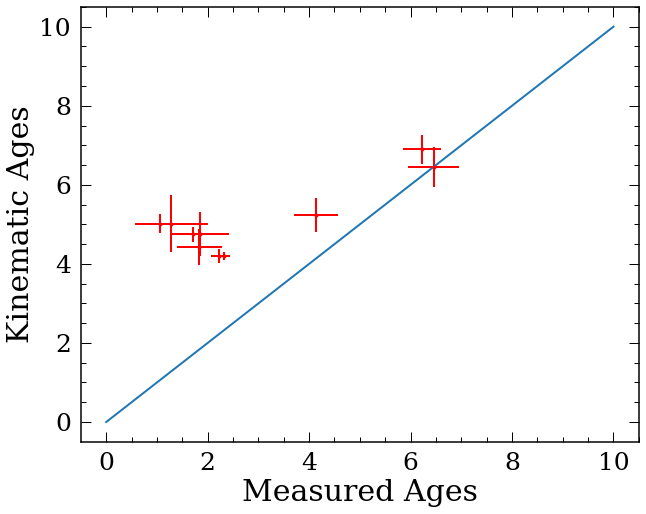

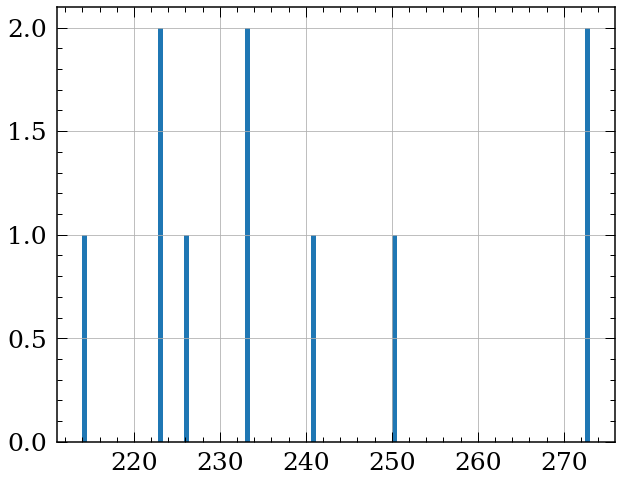

In [27]:
print('optimized bin size:',optbin,'. with chisq:',chisq)
plt.figure(figsize=(10,8))

plt.errorbar(out_comp['measure_age'],out_comp['kin_age'],xerr=out_comp['measure_age_err'],
             yerr=out_comp['measure_age_err'],fmt='r.')
"""
plt.scatter(out_comp['kin_age'],out_comp['measure_age'],c=out_comp['NumbStars'])
"""
plt.plot([0,10],[0,10])
plt.xlabel('Measured Ages')
plt.ylabel('Kinematic Ages')
plt.figure(figsize=(10,8))
out_comp['NumbStars'].hist(bins=100)

In [40]:
df_predict['vel_dis'],df_predict['kin_age']=getkinAges(df_predict,['teff_calc','Prot_log','abs_G','Ro'],
                                                 [450.0, 0.14444444444444446, 0.14444444444444446, 0.4555555555555556],
                                                 vz='v_b',min_star=15,max_star=30)



  1%|          | 458/52120 [00:02<05:15, 163.49it/s]


KeyboardInterrupt: 

In [41]:

compstars(df_predict[['kin_age','KID','kin_age_err','Prot_predict','teff_calc','abs_G','Prot_log','Ro','v_b']],
          err=True,IOfile=False,ave=True)



(24, 146)
(10, 146)
Pleiades
Praesepe
Hyades
NGC_6811
NGC_6819
Ruprecht_147


  0%|          | 214/50186 [04:28<19:35:15,  1.41s/it]

KeyboardInterrupt: 